In [14]:
"""This is just for verifying output dimensions"""

import torch
import torch.nn as nn

input = torch.rand([2, 3, 224, 224])
model = nn.Sequential(
          nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1), #[3 x 224 x 224] ---> [6 x 224 X 224]
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), # [6 x 224 x 224]  --> [6 x 112 x 112]
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), #output : [12 x 56 x 56]
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), #output : [24 x 28 x 28]
            nn.ReLU(inplace=True),
            nn.Flatten(1), #output [24*28*28]
            nn.Linear(24*28*28, 4), 
            nn.Softmax(dim = 1)
)
output = model(input)
print(output.size())

torch.Size([2, 4])


In [15]:

class ImageSelfAttention(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels=input_channels, out_channels=1, kernel_size=1, stride=1, padding=0) #[N, 1, w, h]
        self.key = nn.Conv2d(in_channels=input_channels, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.value = nn.Conv2d(in_channels=input_channels, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.soft_max= nn.Softmax(dim=-1) #Soft max over rows
        self.final_conv = nn.Conv2d(in_channels=1, out_channels=input_channels, kernel_size=1, stride=1, padding=0) #May not use or may modifty
        self.flatten = nn.Flatten(start_dim=-2, end_dim=-1)

    def forward(self, x):
        self.n = torch.tensor(x.size(2) * x.size(3)) #Total number of features
        # q = self.flatten(self.query(x).squeeze()) #[N, w, h]
        # k = self.flatten(self.key(x).squeeze())
        # v = self.flatten(self.value(x).squeeze())
        q = self.query(x).squeeze()
        k = self.query(x).squeeze()
        v = self.query(x).squeeze()
        # print(q.size())
        # print(k.size())
        # attend = torch.matmul(q.transpose(0,1), k) / torch.sqrt(self.n) #[]
        attend = torch.mul(q, k) / torch.sqrt(self.n)
        print(attend.size())
        attend = self.flatten(attend)
        # print(attend.size())
        attend = self.soft_max(attend)
        attend = attend.view(x.size(0), x.size(2), x.size(3))
        # print(attend.size())
        content = torch.mul(attend, v).unsqueeze(1)
        # print(content.size())
        return self.final_conv(content) + x, attend
    

class MCImageSelfAttention(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels=input_channels, out_channels=input_channels, kernel_size=1, stride=1, padding=0) #[N, 1, w, h]
        self.key = nn.Conv2d(in_channels=input_channels, out_channels=input_channels, kernel_size=1, stride=1, padding=0)
        self.value = nn.Conv2d(in_channels=input_channels, out_channels=input_channels, kernel_size=1, stride=1, padding=0)
        self.soft_max = nn.Softmax(dim=-1) #Soft max over columns
        self.upsample= nn.Upsample(scale_factor=4)

    def forward(self, x):
        self.n = torch.tensor(x.size(2) * x.size(3)) #Total number of features
        q = self.query(x)#[N, C, w, h]
        k = self.key(x)
        v = self.value(x)
        attend = torch.matmul(q, k.transpose(2, 3)) / torch.sqrt(self.n) #[]
        attend = self.soft_max(attend)
        return torch.matmul(attend, v) + x, attend
        



In [16]:
selfAttend = ImageSelfAttention(20)
MCselfAttend = MCImageSelfAttention(20)
input = torch.rand(64, 20, 224, 224)
output, att= selfAttend(input)
print(output.size())

torch.Size([64, 224, 224])
torch.Size([64, 20, 224, 224])


In [8]:
test = torch.randn(5, 1, 10, 20)
print(test.size())
trans = test.transpose(2, 3)
print(trans.size())

torch.Size([5, 1, 10, 20])
torch.Size([5, 1, 20, 10])


In [17]:
import torchvision
from torchvision import transforms
dataroot = '../dataset'
image_size = 224
mean = 0
std = 1
batch_size = 64
workers = 2
dataset = torchvision.datasets.ImageFolder(root = dataroot, 
                                            transform=transforms.Compose([
                                                transforms.Resize(image_size), 
                                                transforms.CenterCrop(image_size), 
                                                transforms.ToTensor(), 
                                                transforms.Normalize((mean, mean, mean), (std, std, std))
                                            ]))

#Print some info about the dataset
print(f'Image labels and label index : {dataset.class_to_idx}')
print(f'Dataset size: {len(dataset)}')
# classes = dataset.classes

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset=dataset, lengths= [0.7, 0.1, 0.2])
# train_dataset, val_dataset, test_dataset, _ = torch.utils.data.random_split(dataset=dataset, lengths= [0.2, 0.1, 0.2, 0.5])

'''This is a dataloader, it wraps an iterator around our dataset object. It will return photos in batches of batch_size along with associated labels.
It can do so using multiple threads defined by num_workers'''
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, 
                                            shuffle = True, num_workers=workers)

val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size = batch_size, 
                                            shuffle = True, num_workers=workers)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = batch_size, 
                                            shuffle = True, num_workers=workers)

'''Use this to visualize a batch of input images'''
# if printBatch:
#     batch = next(iter(train_dataloader))
#     plt.figure(figsize=(8,8))
#     plt.axis('off')
#     plt.imshow(np.transpose(torchvision.utils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
#     plt.show()

Image labels and label index : {'AugmentedAlzheimerDataset': 0, 'OriginalDataset': 1}
Dataset size: 40384


'Use this to visualize a batch of input images'

In [20]:
class ImageSelfAttention_4(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels=input_channels, out_channels=1, kernel_size=1, stride=1, padding=0) #[N, 1, w, h]
        self.key = nn.Conv2d(in_channels=input_channels, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.value = nn.Conv2d(in_channels=input_channels, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.soft_max= nn.Softmax(dim=-1) #Soft max over rows
        self.final_conv = nn.Conv2d(in_channels=1, out_channels=input_channels, kernel_size=1, stride=1, padding=0) #May not use or may modifty
        self.flatten = nn.Flatten(start_dim=-2, end_dim=-1)

    def forward(self, x):
        self.n = torch.tensor(x.size(2) * x.size(3)) #Total number of features
        # q = self.flatten(self.query(x).squeeze()) #[N, w, h]
        # k = self.flatten(self.key(x).squeeze())
        # v = self.flatten(self.value(x).squeeze())
        q = self.query(x).squeeze()
        k = self.query(x).squeeze()
        v = self.query(x).squeeze()
        # print(q.size())
        # print(k.size())
        # attend = torch.matmul(q.transpose(0,1), k) / torch.sqrt(self.n) #[]
        attend = torch.mul(q, k) / torch.sqrt(self.n)
        # print(attend.size())
        attend = self.flatten(attend)
        # print(attend.size())
        attend = self.soft_max(attend)
        attend = attend.view(x.size(0), x.size(2), x.size(3))
        # print(attend.size())
        content = torch.mul(attend, v).unsqueeze(1)
        # print(content.size())
        return self.final_conv(content) + x, attend


torch.Size([64, 3, 224, 224])
torch.Size([64, 224, 224])


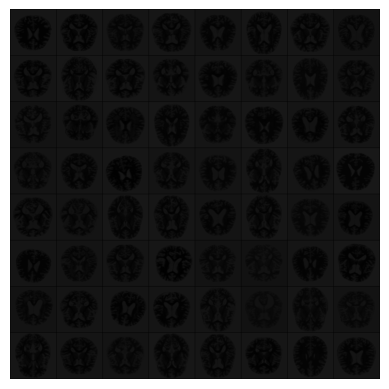

In [32]:
from matplotlib import pyplot as plt
import numpy as np
model = torch.load('../models/ResNet_E[4].pth')
input = next(iter(train_dataloader))[0].cuda()
output, atten = model(input)
print(input.size())
print(atten.size())
# plt.figure(8,8)
plt.axis('off')
plt.imshow(np.transpose(torchvision.utils.make_grid(atten.to('cuda:0')[:64].unsqueeze(1), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()